In [1]:
#| default_exp BaltNet
#| default_cls_lvl 3

# BaltNet

Model architecture used for predicting river runoff in the Baltic Sea

In [2]:
#| export

import torch
import torch.nn as nn
import lightning as L
import pytorch_lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

import xarray as xr
from glob import glob
from tqdm import tqdm

from BalticRiverPrediction.convLSTM import ConvLSTM
from BalticRiverPrediction.sharedUtilities import read_netcdfs, preprocess, plot_loss_and_acc

In [3]:
#| export
class BaltNet(nn.Module):
    def __init__(self, modelPar):
        super(BaltNet, self).__init__()

        # initialize all attributes
        for k, v in modelPar.items():
            setattr(self, k, v)

        self.linear_dim = self.dimensions[0]*self.dimensions[1]*self.hidden_dim

        self.convLSTM = ConvLSTM(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                kernel_size=self.kernel_size,
                num_layers=self.num_layers,
                batch_first=self.batch_first,
                bias=self.bias,
                return_all_layers=self.return_all_layers
        )

        self.convLSTM2 = ConvLSTM(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                kernel_size=self.kernel_size,
                num_layers=1,
                batch_first=self.batch_first,
                bias=self.bias,
                return_all_layers=self.return_all_layers
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.linear_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 97)
            )

    def forward(self, x):
        _, encode_state = self.convLSTM(x)
        decoder_out, _ = self.convLSTM2(x[:,-1:,:,:,:], encode_state)
        x = decoder_out[0]
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x).squeeze()
        return x


In [4]:
#| export
class BaseLineModel(nn.Module):
    def __init__(self, modelPar):
        super(BaseLineModel, self).__init__()

        # initialize all attributes
        for k, v in modelPar.items():
            setattr(self, k, v)

        self.linear_dim = self.dimensions[0]*self.dimensions[1]*self.hidden_dim*self.input_dim

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.linear_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
            )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x).squeeze()
        return x

In [5]:
#| export

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_t_max):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.cosine_t_max = cosine_t_max

        self.save_hyperparameters(ignore=["model"])

        self.train_mse = torchmetrics.MeanSquaredError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.test_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, debug=False):
        features, true_labels = batch
        logits = self.model(features)
        loss = F.mse_loss(logits, true_labels)
        if debug == True:
            print(loss)
        return loss, true_labels, logits
    
    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, debug=False)
        mse = self.train_mse(predicted_labels, true_labels)
        metrics = {"train_mse":mse, "train_loss":loss}
        self.log_dict(metrics, on_step=True, on_epoch=True, prog_bar=True,logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, true_labes, predicted_labels = self._shared_step(batch)
        mse = self.val_mse(predicted_labels, true_labes)
        self.log("val_loss", loss, sync_dist=True)
        self.log("val_mse", mse, prog_bar=True, sync_dist=True)
    
    def test_step(self, batch, _):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        mse = self.test_mse(predicted_labels, true_labels)
        self.log("test_loss", loss, rank_zero_only=True)
        self.log("test_mse", mse, sync_dist=True)
        return loss
    
    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        _, _, predicted_labels = self._shared_step(batch)
        return predicted_labels

    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.cosine_t_max)

        return [opt], [sch]


In [6]:
#| export
class AtmosphericDataset(Dataset):
    def __init__(self, input_size, data, runoff, transform=None):


        # Following the technical description of the river data (Germo et al.)
        # the original river data is limited to 1979 to 2011

        start_year, end_year = 1979, 2011
        self.timeRange = slice(str(start_year), str(end_year))
        self.input_size = input_size

        runoffData = runoff.transpose("time", "river")
        runoffDataMean = runoffData.mean("time")
        runoffDataSTD = runoffData.std("time")

        rainData = data["RAIN"].sel(time=self.timeRange)
        rainDataMean = rainData.mean("time")
        rainDataSTD = rainData.std("time")

        self.rainData = (rainDataMean, rainDataSTD)
        self.runoffData = (runoffDataMean, runoffDataSTD)

        np.savetxt(
            "/silor/boergel/paper/runoff_prediction/data/runoffMeanStd.txt",
            [runoffDataMean, runoffDataSTD]
        )

        X = (rainData - rainDataMean)/rainDataSTD
        y = (runoffData - runoffDataMean)/runoffDataSTD

        # TODO 
        # add dummy dimension in only one atmospheric data file
        # is loaded
        
        X = ((rainData - rainDataMean) / rainDataSTD).compute()
        y = ((runoffData - runoffDataMean) / runoffDataSTD).compute()

        X = torch.tensor(X.data, dtype=torch.float32).unsqueeze(dim=0)
        self.x = X
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[:, index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)


In [7]:
#| export
class AtmosphereDataModule(L.LightningDataModule):
    def __init__(self, data, runoff, batch_size=64, num_workers=8, add_first_dim=True, input_size=30):
        super().__init__()

        self.data = data
        self.runoff = runoff
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.add_first_dim = add_first_dim
        self.input_size = input_size
    
    def setup(self, stage:str):
        UserWarning("Loading atmospheric data ...")
        dataset = AtmosphericDataset(data=self.data, runoff=self.runoff, input_size=self.input_size)
        n_samples = len(dataset)
        train_size = int(0.8 * n_samples)
        val_size = int(0.1 * n_samples)
        test_size = n_samples - train_size - val_size
        self.train, self.val, self.test = random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True, 
            drop_last=True, 
            num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(
            dataset=self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=True)

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers, 
            drop_last=True)

In [8]:
import ray
from ray import tune
import ray.train.lightning
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.tune.schedulers import ASHAScheduler

In [9]:
# Our GPU has tensor cores, hence mixed precision training is enabled
# see https://sebastianraschka.com/blog/2023/llm-mixed-precision-copy.html
# for more

torch.set_float32_matmul_precision("medium")

In [10]:
L.pytorch.seed_everything(123)

Global seed set to 123


123

In [18]:
datapath="/silor/boergel/paper/runoff_prediction/data"

data = read_netcdfs(
    files=f"{datapath}/atmosphericForcing/????/rain.mom.dta.nc",
    dim="time",
    transform_func=lambda ds:preprocess(ds)
    )       

runoff = read_netcdfs(
    f"{datapath}/runoffData/combined_fastriver_*.nc",
    dim="river",
    transform_func= lambda ds:ds.sel(time=slice(str(1979), str(2011))).roflux.resample(time="1D").mean(),
    cftime=False
    )  


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 97/97 [03:50<00:00,  2.37s/it]


In [12]:
 config = {
    "input_dim":32, # timesteps
    "hidden_dim":1, # Channels -> right now only precipitation
    "kernel_size":(7,7), # applied for spatial convolutions
    "num_layers":4, # number of convLSTM layers
    "batch_first":True, # first index is batch
    "bias":True, 
    "return_all_layers": False, 
    "dimensions": (191, 206) # dimensions of atmospheric forcing
    }

In [19]:
dataLoader = AtmosphereDataModule(
    data=data,
    runoff=runoff,
    batch_size=64,
    input_size=config["input_dim"]
    )

In [20]:
dataLoader.setup(stage="")

In [29]:
loader =  dataLoader.train

In [32]:
loader[0][0]

tensor([[[[-0.4250, -0.4403, -0.4350,  ..., -0.1448, -0.4407, -0.4181],
          [-0.4503, -0.4728, -0.4843,  ..., -0.1200,  0.1103, -0.0869],
          [-0.4288, -0.4525, -0.4861,  ...,  0.5932,  0.5412,  0.4747],
          ...,
          [-0.5626, -0.5615, -0.5588,  ..., -0.5344, -0.5322, -0.5363],
          [-0.5474, -0.5528, -0.5431,  ..., -0.5367, -0.5340, -0.5379],
          [-0.5327, -0.5482, -0.5324,  ..., -0.5384, -0.5382, -0.5401]],

         [[-0.4495, -0.4403, -0.4306,  ...,  2.8955,  2.8067,  3.0179],
          [-0.4277, -0.4118, -0.3649,  ...,  3.1623,  2.3495,  1.4009],
          [-0.4092, -0.3182, -0.3193,  ...,  1.3156,  0.6189,  0.3315],
          ...,
          [-0.5205, -0.5239, -0.5241,  ..., -0.5339, -0.5318, -0.5359],
          [-0.5339, -0.5432, -0.5337,  ..., -0.5364, -0.5340, -0.5378],
          [-0.5229, -0.5354, -0.5376,  ..., -0.5384, -0.5382, -0.5400]],

         [[-0.2523, -0.1741, -0.2253,  ...,  0.3800,  0.1439,  0.0412],
          [-0.3345, -0.3287, -

In [13]:
# initalize model
pyTorchBaltNet = BaltNet(modelPar=config)

# Lightning model wrapper
LighningBaltNet = LightningModel(
    pyTorchBaltNet,
    learning_rate=1e-3,
    cosine_t_max=50
)


In [35]:
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(pyTorchBaltNet, loader[0][0].unsqueeze(0), '../data/ConvLSTM.onnx', input_names=input_names, output_names=output_names)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [17]:
from torchviz import make_dot


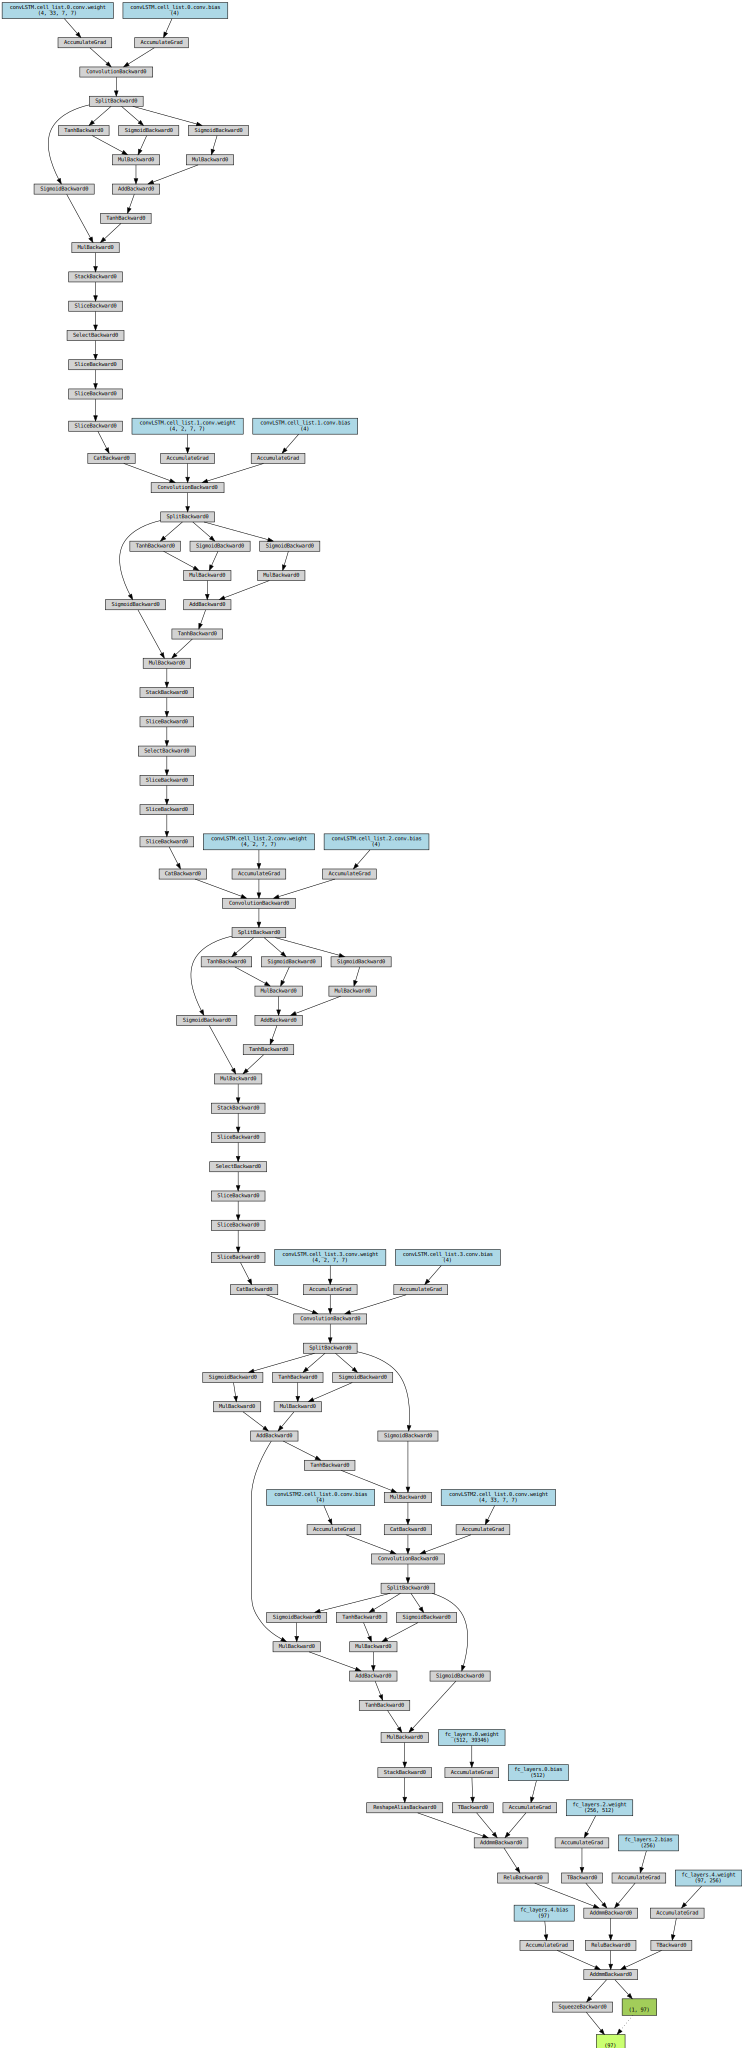

In [43]:
make_dot(pyTorchBaltNet(loader[0][0].unsqueeze(0)), params=dict(pyTorchBaltNet.named_parameters()))

In [14]:
torch.save(pyTorchBaltNet, "../data/model.h5")

In [15]:
!ls -lisah ../data/model.h5

13200003479 78M -rw-r--r-- 1 boergel modell 78M Sep 29 18:19 ../data/model.h5


In [79]:
LighningBaltNet(dataLoader.train[0][0].unsqueeze(0))

RuntimeError: The size of tensor a (207) must match the size of tensor b (206) at non-singleton dimension 3

In [11]:
num_epochs = 50

# initalize model
pyTorchBaltNet = BaltNet(modelPar=config)

# Lightning model wrapper
LighningBaltNet = LightningModel(
    pyTorchBaltNet,
    learning_rate=1e-3,
    cosine_t_max=num_epochs
)

NameError: name 'config' is not defined

In [ ]:
pyT

In [16]:
ray.init()

2023-09-27 10:23:06,653	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.7.0


In [17]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    strategy=ray.train.lightning.RayDDPStrategy(),
    callbacks=[ray.train.lightning.RayTrainReportCallback()],
    plugins=[ray.train.lightning.RayLightningEnvironment()],
    max_epochs=num_epochs
)

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'

In [ ]:
trainer = ray.train.lightning.prepare_trainer(trainer)
trainer.fit(model=LighningBaltNet, datamodule=dataLoader)